# Import packages

### Import python packages

In [1]:
import re,os,glob
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from scipy.stats import linregress
from sklearn.decomposition import PCA
from tqdm import trange, tqdm
from mpl_toolkits.mplot3d import Axes3D
import plotly.express as px
import plotly.graph_objects as go
from sklearn.manifold import TSNE
import scipy
from scipy import interpolate
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()
from MRA_generate import MRA_generate
from parameters import *
import symae_core as symae
from movie_redatum import movie_redatum 

# Generate dataset X

In [2]:
d

100

### Define $n_\varepsilon$ states

In [3]:
def g(n,x):
    if n==0:
        return int(x<0.5)
    elif n==1:
        return math.cos(2*math.pi*x)/2 + 0.5
    elif n==2:
        if x<0.5: 
            return 1-2*x
        else:     
            return 0
    elif n==3:
        return 2*int(x<0.5)-1
    elif n==4:
        return math.cos(2*math.pi*x)
    elif n==5:
        if x<0.5: 
            return 1-4*x
        else:     
            return -1

Text(0.5, 0.98, 'Show the shape of all $n_\\epsilon$ = 6 states')

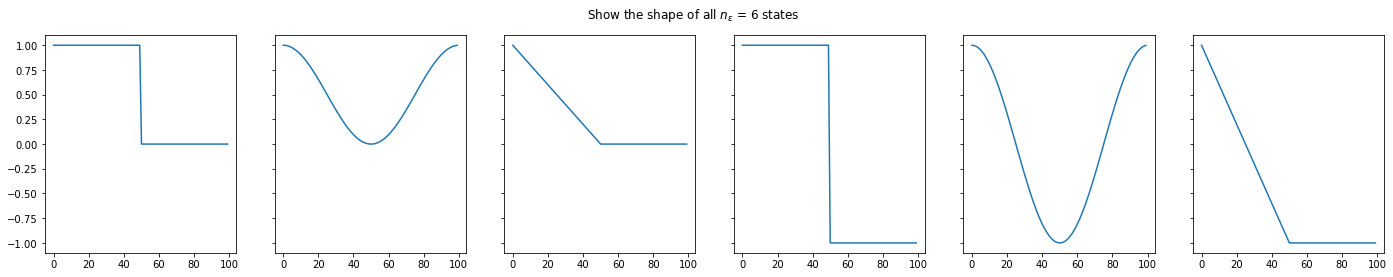

In [4]:
fig, axs = plt.subplots(1, ne, sharex=True, sharey=True, figsize=(ne*4, 4))
for i in range(ne):
    axs[i].plot(range(d), [g(i,x/d) for x in range(d)])
plt.suptitle('Show the shape of all $n_\epsilon$ = %d states'%ne)

### Generate the dataset

In [5]:
MRA_training = MRA_generate(d,nt,N,0,ne,g,replace=0,continuous=False)
while np.min(np.sum(MRA_training.select_times,axis=1))==0:
    MRA_training.generate_default()
X = MRA_training.X
states = MRA_training.states
shifts = MRA_training.shifts

### Print the structure of dataset X

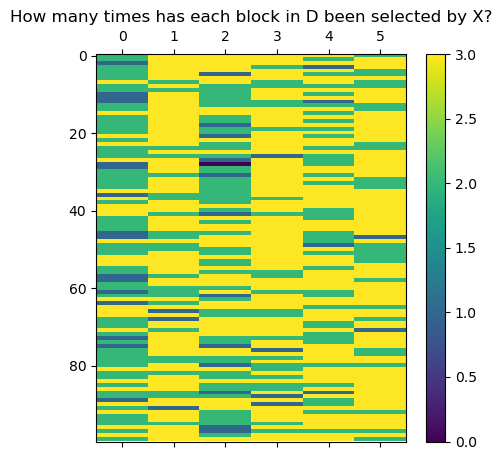

In [6]:
select_times = MRA_training.select_times
plt.figure(figsize=(5,5),dpi=100)
plt.matshow(select_times.T, aspect='auto', fignum=1)
plt.colorbar()
plt.title('How many times has each block in D been selected by X?')
plt.show()

# Train SymAE

In [7]:
nt

15

### Layer

In [8]:
class LatentCat(tf.keras.Model):
    def __init__(self, alpha=0.5):
        super(LatentCat, self).__init__(name = 'latentcat')
        self.drop = tfkl.Dropout(alpha)
    def call(self, zsym, znuisance, training=False):
        znuisance = self.drop(znuisance, training=training)
        znuisance = tfkl.Flatten()(znuisance)
        z = tfkl.concatenate([zsym, znuisance])
        return z

In [9]:
class SymAE(tf.keras.Model):
    def __init__(self, N, nt, d, p, q, r): 
        super(SymAE, self).__init__()
        # Build symmetric encoder
        sym_encoder = symae.SymmetricEncoder1D(p)
        self.sym_encoder = sym_encoder
        
        # Build nuisance encoder
        nui_encoder = symae.NuisanceEncoder1D(q)
        self.nui_encoder = nui_encoder
        
        # Build distribute in decoder
        distzsym = symae.DistributeZsym(nt, p, q)
        self.distzsym = distzsym
        
        #Build decoder
        sym_dec = symae.DecDense1()
        self.sym_dec = sym_dec
        nui_dec = symae.DecDense2()
        self.nui_dec = nui_dec
        dec = symae.DecDense()
        self.dec = dec
        
        # Build latentcat
        latentcat = LatentCat(r)
        self.latentcat = latentcat        
        
        # Build encoder
        encoder_input = tfk.Input(shape=(nt,d,1), dtype='float32', name='encoder_input')
        znuisance = nui_encoder(encoder_input)
        zsym = sym_encoder(encoder_input)
        encoder_output = latentcat(zsym,znuisance)
        encoder = tfk.Model(encoder_input, encoder_output, name="encoder")
        self.encoder = encoder
        
        # Build decoder
        decoder_input = tfk.Input(shape=(p+q*nt), name='latentcode')
        z = distzsym(decoder_input)
        z1 = z[:,:,0:p]
        z2 = z[:,:,p:p+q]
        y1 = sym_dec(z1)
        y2 = nui_dec(z2)
        tf.print(y1.shape,y2.shape)
        y = y1*y2
        decoder_output = dec(y)
        decoder = tfk.Model(decoder_input,decoder_output, name="decoder") 
        self.decoder = decoder
        
    def call(self, x):
        return self.decoder(self.encoder(x))

### Initialize SymAE and load weights

In [10]:
my_list=[(2, 10, 0.5, 0)
        ]

In [11]:
for (p,q,r,lam) in my_list:
    path = './ber,N=%d,nt=%d,p=%d,q=%d,r=%.1f,l=%.2f'%(N,nt,p,q,r,lam)    
    model = SymAE(N,nt,d,p,q,r)
    clear_output()
    try: 
        model.load_weights(path+'/checkpoint')
        print("old")    
    except:
        print("new")
    optimizer = tf.keras.optimizers.Adam(0.001)
    mse = tf.keras.losses.MeanSquaredError()

    def reconstruction_loss(model, x, training=False):
        x_hat = model(x, training=True)
        return mse(x, x_hat)
    @tf.function
    def train_step(model, x, training=True):
        with tf.GradientTape() as tape:
            loss_rec = reconstruction_loss(model, x, training)
            loss_cor = 0
            loss = loss_rec + loss_cor
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss_rec, loss_cor

    try:
        os.mkdir(path)
    except:
        print('exists')
    try:
        epoch = int(re.findall(r"\d+",glob.glob(path+'/*.epoch')[0])[-1])
        print(epoch)
    except:
        epoch = 0
        os.mkdir(path+'/0.epoch')

    for i in range(1000):
        epoch += 1
        os.mkdir(path+'/%d.epoch'%epoch)
        os.rmdir(path+'/%d.epoch'%(epoch-1))    
        loss_rec, loss_cor = train_step(model, X)
        print("For epoch {:d}, reconstruction loss is {:f}, correlation loss is {:f}."
              .format(epoch, loss_rec, loss_cor))
        clear_output(wait=True)
        if epoch%1000==0:
            model.save_weights(path+'/checkpoint')

    model.save_weights(path+'/checkpoint')
    print("weights saved")

    fig = movie_redatum(g,model)
    fig.savefig(path+"/redatum.pdf", format='pdf', dpi=200)

    MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
    MRA_test.generate_default()
    clear_output()
    N_states = np.repeat(MRA_test.states,nt)
    N_shifts = MRA_test.shifts.reshape(-1,1)
    df_states = pd.DataFrame(1+N_states,columns=['state']).astype('object')
    df_shifts = pd.DataFrame(N_shifts,columns=['shift'])

    N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
    N_reshaped = N_code.reshape(-1,q)
    pca_N = PCA(2).fit_transform(N_reshaped)
    df = pd.DataFrame(pca_N, columns = ['first principal component','second principal component'])
    df = pd.concat([df,df_states,df_shifts],axis=1)
    df = df.sort_values(by=['state'])
    fig = px.scatter(df, x='first principal component', y='second principal component', 
                     color='state', text='shift')
    fig.update_layout(width=500, height=400, title="PCA of latent nuisance codes")
    fig.show()
    fig.write_image(path+'/latent.pdf')

2022-09-08 11:05:54.868132: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-08 11:05:55.621163: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 24 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:b1:00.0, compute capability: 8.6


ValueError: Exception encountered when calling layer "DecDense1" (type DecDense1).

in user code:

    File "/math/home/eruisun/github/SymAE/MRA/new_decoder/symae_core.py", line 133, in call  *
        x=self.r2(x)
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "/math/home/eruisun/software/anaconda/envs/MRA/lib/python3.9/site-packages/keras/layers/reshaping/reshape.py", line 111, in _fix_unknown_dimension
        raise ValueError(msg)

    ValueError: Exception encountered when calling layer "reshape_1" (type Reshape).
    
    total size of new array must be unchanged, input_shape = [50], output_shape = [5, 1]
    
    Call arguments received by layer "reshape_1" (type Reshape):
      • inputs=tf.Tensor(shape=(None, 50), dtype=float32)


Call arguments received by layer "DecDense1" (type DecDense1):
  • x=tf.Tensor(shape=(None, 15, 2), dtype=float32)
  • training=False

In [ ]:
fig = movie_redatum(g,model)

In [ ]:
model(X).shape

In [ ]:
MRA_test = MRA_generate(d,nt,100,sigma,ne,g,replace=0,continuous=False)
MRA_test.generate_default()
clear_output()
N_code = model.nui_encoder.predict(MRA_test.X,verbose=0)
N_reshaped = N_code.reshape(-1,q)
N_states = np.repeat(MRA_test.states,nt)
N_shifts = MRA_test.shifts.reshape(-1,1)
s_sub = [N_states==s for s in range(ne)]
fig, axs = plt.subplots(1, q, sharex=True, sharey=True, figsize=(q*5,5))
for i in trange(q):
    for s in range(ne):
        ax=axs[i]
        ax.scatter(N_shifts[s_sub[s]],N_reshaped[:,i][s_sub[s]],color='C%d'%s,label=s)
        ax.set_title('%d-th dim'%i)
        ax.set_xlabel('real shift')
        ax.set_ylabel('%d-th latent'%i)
        ax.legend()
        ax.grid()
fig.suptitle('latent nuisance space')
fig.show()
fig.tight_layout()
fig.savefig(path+"/redatum_all.pdf", format='pdf', dpi=200)

In [ ]:
Z = model.distzsym(model.encoder(X))
Z.shape

In [ ]:
Z1 = model.sym_dec(Z[:,:,0:p])
Z1 = tf.reshape(Z1, (600,-1)).numpy()
Z2 = model.nui_dec(Z[:,:,p:p+q])
Z2 = tf.reshape(Z2, (600,-1)).numpy()

In [ ]:
data=[]
colors=[
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]
for i in range(N):
    s=i
    data.append(go.Scatter(x=list(range(100)), 
                           y=Z1[i*nt,:], 
                           mode='markers', 
                           name='dataset',
                           marker_color=colors[states[s]],
                           showlegend=False))
fig=go.Figure(data)
fig.update_layout(title="Net(C),color=state,x=10-dim")
#plt.plot(Z1)
#clear_output()
fig

In [ ]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(10,5))
for i in trange(1):
    for j in range(N*nt):
        s=j//nt
        l=j%nt
        ax=axs[i]
        ax.scatter(shifts[s,l],Z2[j,i],color='C%d'%states[s])
        ax.set_title('%d-th dim'%i)
        ax.set_xlabel('real shift')
        ax.set_ylabel('%d-th latent'%i)
        #ax.legend()
        ax.grid()
fig.suptitle('latent nuisance space')
fig.show()
fig.tight_layout()


In [ ]:
ZZ = Z1*Z2
data=[]
colors=[
    '#1f77b4',  # muted blue
    '#ff7f0e',  # safety orange
    '#2ca02c',  # cooked asparagus green
    '#d62728',  # brick red
    '#9467bd',  # muted purple
    '#8c564b',  # chestnut brown
    '#e377c2',  # raspberry yogurt pink
    '#7f7f7f',  # middle gray
    '#bcbd22',  # curry yellow-green
    '#17becf'   # blue-teal
]
for i in range(N*nt):
    s=i//nt
    l=i%nt
    if shifts[s,l]==50:
        data.append(go.Scatter(x=list(range(10)), 
                           y=ZZ[i,:], 
                           mode='markers', 
                           name='dataset',
                           marker_color=colors[states[s]],
                           showlegend=False))
fig=go.Figure(data)
fig.update_layout(title="Net(C)*Net(N),color=state,x=10-dim,shift=0")
#plt.plot(Z1)
#clear_output()
fig